<a href="https://colab.research.google.com/github/jobellet/Dynamics-of-Visual-Representations-in-a-Macaque-Ventrolateral-Prefrontal-Cortex/blob/main/Dynamics_of_representational_geometry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

-----------------------------------------------------------------------------
# Representational Geometry in vlPFC
-----------------------------------------------------------------------------
#### This notebook replicates the analysis quantifying the dynamics of representational geometry of neuronal ensembles in the vlPFC in response to the 2560 stimuli with high variation (object pose and size and landscape background)
----
For the notebook to download the data from the Figshare repository prior to acceptance of the manuscript you need to insert the private link token mentioned in the "Code availability" section of the manuscript.
----

In [ ]:
private_link = input('Enter the private link token:')

# Analysis

Cloning into 'Dynamics-of-Visual-Representations-in-a-Macaque-Ventrolateral-Prefrontal-Cortex'...
remote: Enumerating objects: 53, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 53 (delta 17), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (53/53), 2.74 MiB | 9.29 MiB/s, done.
Resolving deltas: 100% (17/17), done.
Successfully downloaded downloads/Spike_count_even_sessions.npy.
Successfully downloaded downloads/Spike_count_odd_sessions.npy.
Run 1/10 done (pair-unique).
Run 2/10 done (pair-unique).
Run 3/10 done (pair-unique).
Run 4/10 done (pair-unique).
Run 5/10 done (pair-unique).
Run 6/10 done (pair-unique).
Run 7/10 done (pair-unique).
Run 8/10 done (pair-unique).
Run 9/10 done (pair-unique).
Run 10/10 done (pair-unique).


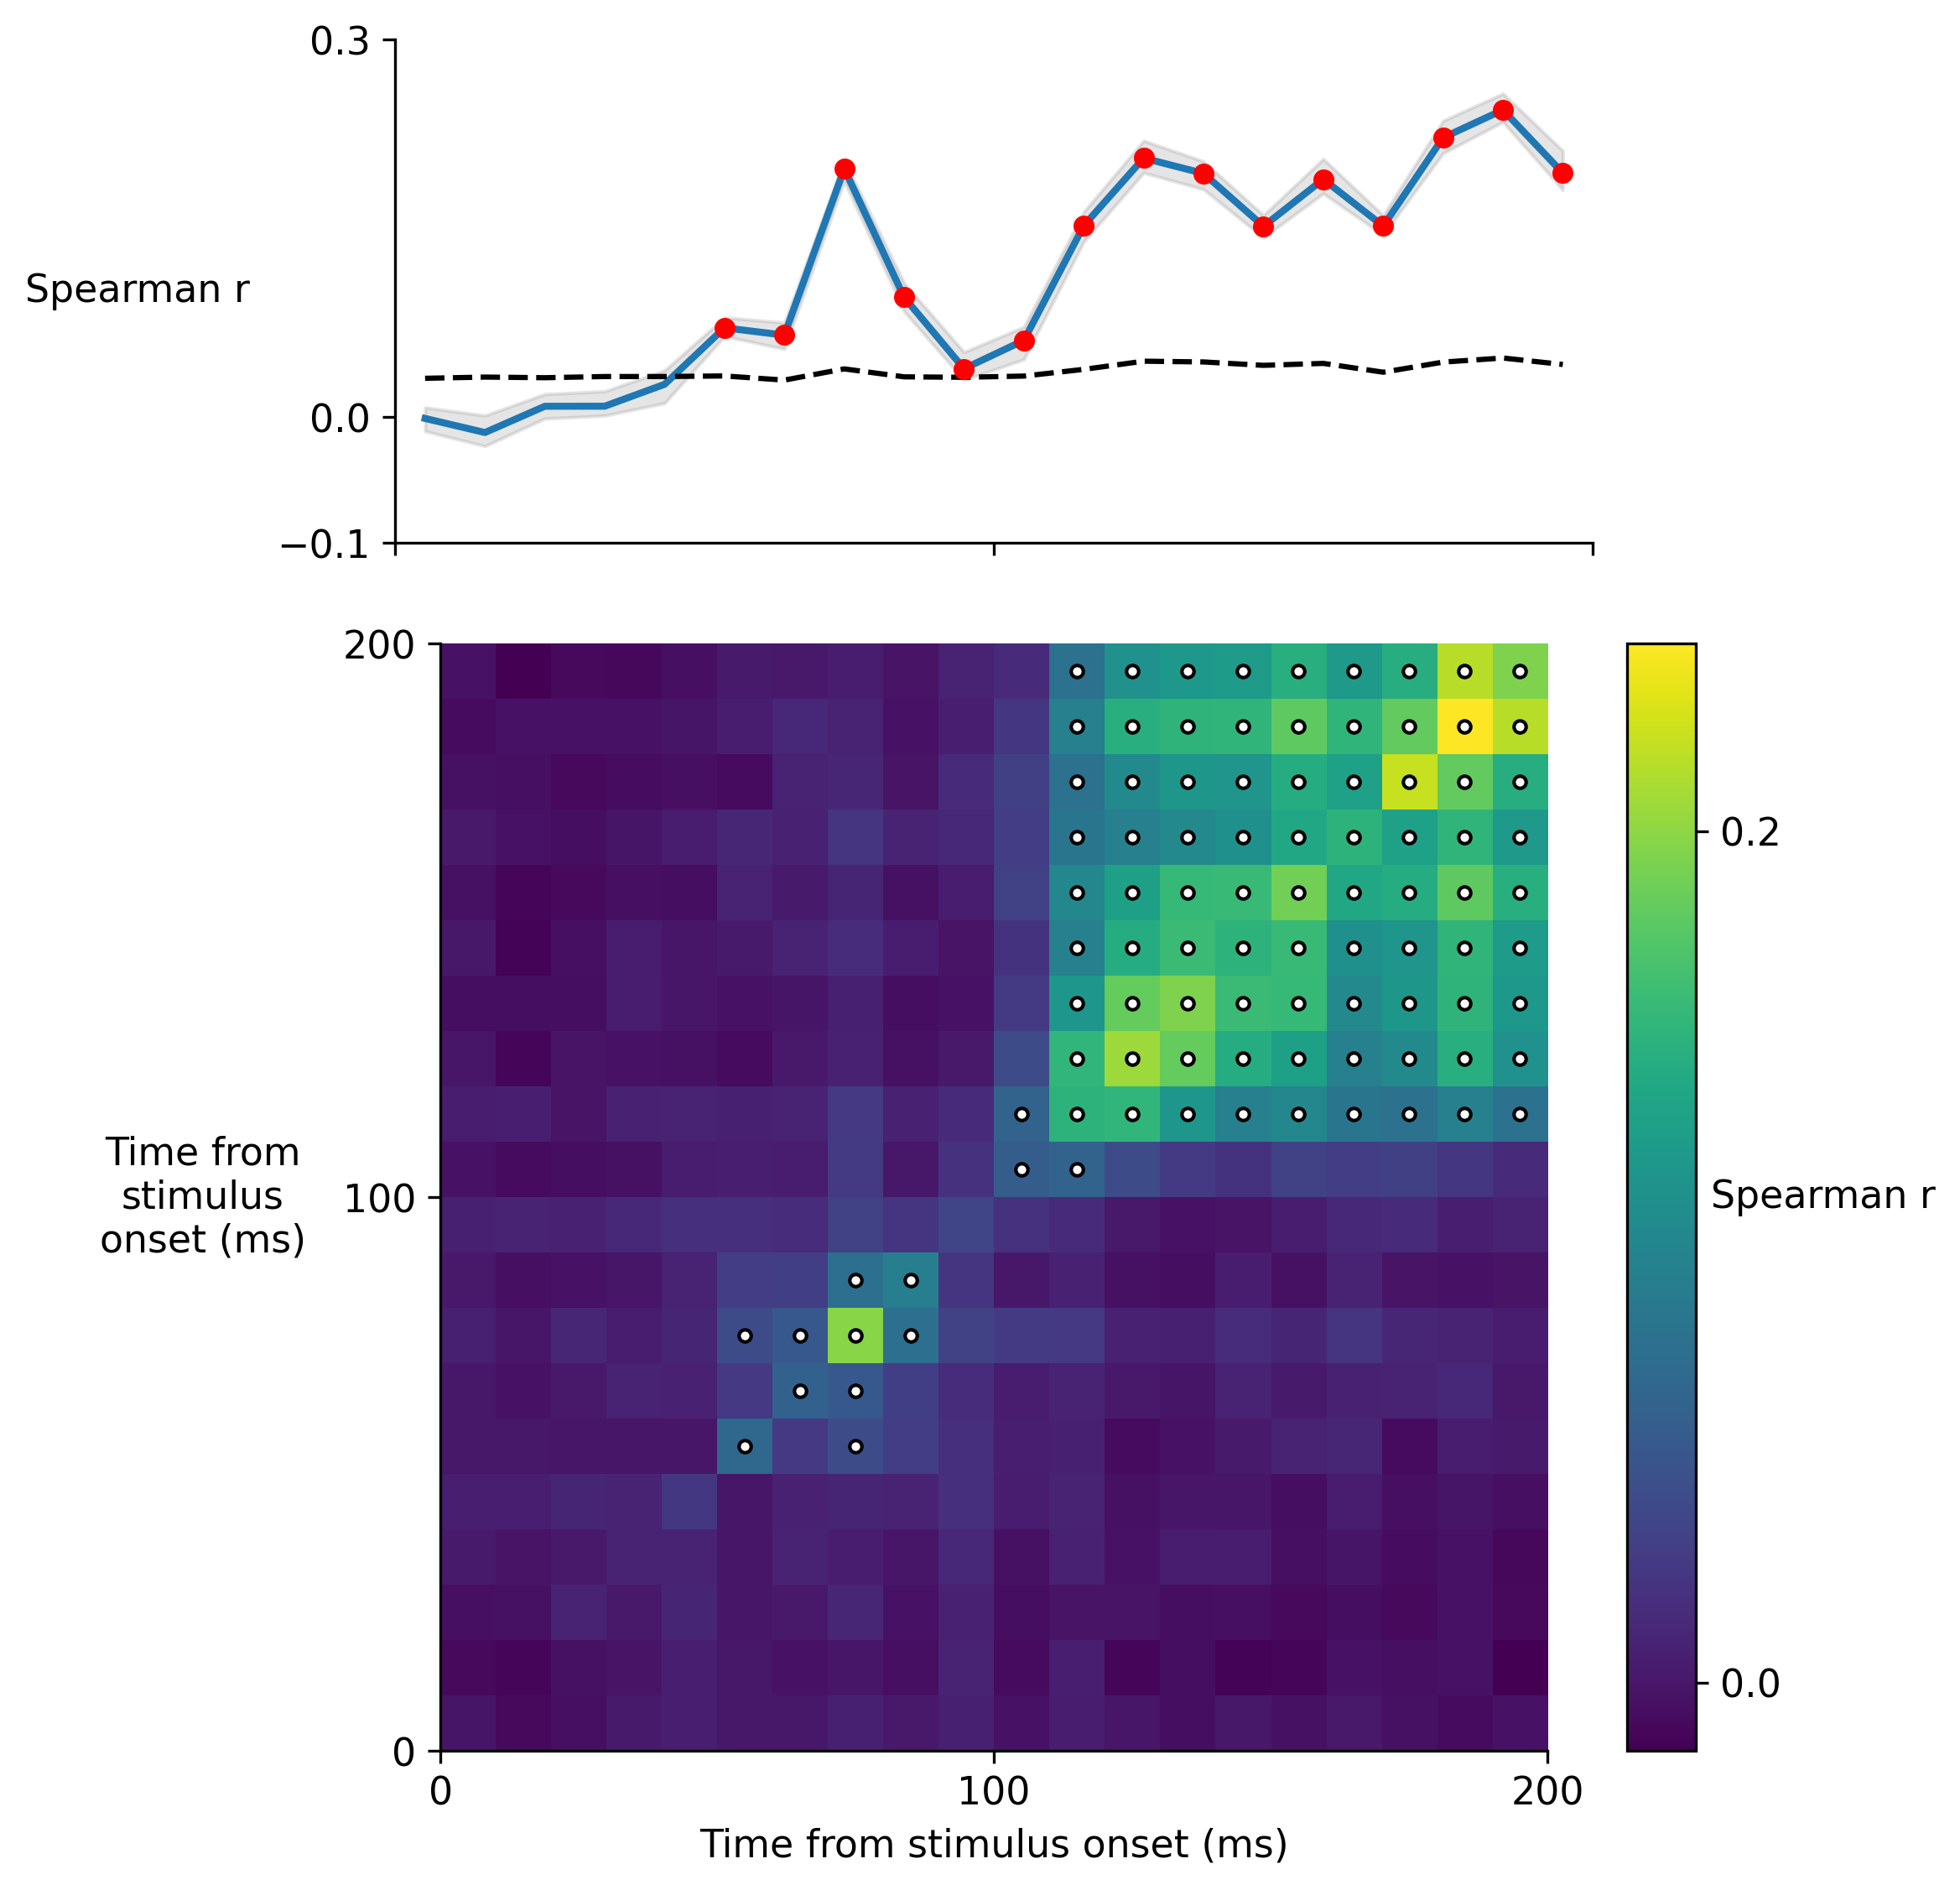

In [5]:
import os
import sys
IN_COLAB = False
IN_KAGGLE = False
try:
    if 'google.colab' in str(get_ipython()):
        IN_COLAB = True
except NameError:
    pass
if not IN_COLAB:
    if os.environ.get('KAGGLE_KERNEL_RUN_TYPE', 'Localhost') == 'Interactive':
        IN_KAGGLE = True



if IN_COLAB:
    path_to_repo = '/content/Dynamics-of-Visual-Representations-in-a-Macaque-Ventrolateral-Prefrontal-Cortex'
elif IN_KAGGLE:
    path_to_repo = '/kaggle/working/Dynamics-of-Visual-Representations-in-a-Macaque-Ventrolateral-Prefrontal-Cortex'
else:
    path_to_repo = 'Dynamics-of-Visual-Representations-in-a-Macaque-Ventrolateral-Prefrontal-Cortex/'
# Only clone if not already present
if not os.path.exists(path_to_repo):
    !git clone https://github.com/jobellet/Dynamics-of-Visual-Representations-in-a-Macaque-Ventrolateral-Prefrontal-Cortex.git
sys.path.append(path_to_repo)


from utils.extract_and_download_data import download_files, unzip

# Load the file-code mapping
files_to_download = ['Spike_count_even_sessions.npy','Spike_count_odd_sessions.npy']
download_files(path_to_repo, files_to_download, private_link=private_link)

# 0. Parameters
batch_size   = 16          # fixed (→ 16 pairs per batch)
n_runs       = 10          # first 10 round-robin rounds → 10 pair-unique runs
n_surrogates = 2_000       # per run
alpha        = 0.05
skip_first   = 640         # Only include high-variation stimuli

# 1. Imports
import numpy as np, jax, jax.numpy as jnp
import matplotlib.pyplot as plt, seaborn as sns
from itertools import combinations
from scipy.stats import rankdata
from statsmodels.stats.multitest import multipletests
import subprocess, pathlib, warnings
warnings.filterwarnings("ignore", category=FutureWarning)

rng_global   = np.random.default_rng(42)

# 2. Helpers
def _upper(n):
    iu, ju = np.triu_indices(n, 1)
    return tuple(iu.tolist()), tuple(ju.tolist())

def make_pw_euclid(batch):
    iu, ju = _upper(batch)
    def _pw(X, *, iu=iu, ju=ju):
        iu_a, ju_a = jnp.array(iu), jnp.array(ju)
        diff = X[:, None, :] - X[None, :, :]
        return jnp.sum(diff**2, axis=-1)[iu_a, ju_a]
    return jax.jit(_pw, static_argnames=("iu", "ju"))

def rank_safe(a):
    if a.ndim == 1:
        return rankdata(a)
    return np.vstack([rankdata(a[:, i]) for i in range(a.shape[1])]).T

def batch_rdm(data, idx, pw):
    X, T = data[idx], data.shape[-1]
    r = np.empty((len(idx)*(len(idx)-1)//2, T), np.float64)
    for t in range(T):
        r[:, t] = np.asarray(pw(jnp.asarray(X[:, :, t])))
    return r

def fdr_triu(p_mat, *, alpha=0.05):
    """
    Run BH-FDR on the upper triangle (including the diagonal) of a square
    p-value matrix and mirror results to full size.
    Returns: sig_mask (bool, same shape as p_mat), q_full (float, same shape)
    """
    iu, ju = np.triu_indices_from(p_mat, k=0)
    pvec   = p_mat[iu, ju]
    reject, qvec, *_ = multipletests(pvec, alpha=alpha, method="fdr_bh")
    sig  = np.zeros_like(p_mat, dtype=bool)
    qmat = np.ones_like(p_mat, dtype=float)
    sig[iu, ju] = reject
    qmat[iu, ju] = qvec
    # mirror to lower triangle
    sig[ju, iu] = sig[iu, ju]
    qmat[ju, iu] = qmat[iu, ju]
    return sig, qmat

# 3. Round-robin “speed-dating” pairs  -----------------------------------
def round_robin_pairs(n, rng):
    players = list(range(n))
    rounds = []
    for r in range(n - 1):
        pairs = [(players[i], players[-i-1]) for i in range(n // 2)]
        rng.shuffle(pairs)
        rounds.append(pairs)
        players = [players[0]] + [players[-1]] + players[1:-1]
    return rounds

def round_to_batches(pairs_round):
    pairs_round = list(pairs_round)
    batches = []
    for i in range(0, len(pairs_round), 8):
        chunk = pairs_round[i:i+8]
        flat  = [j for p in chunk for j in p]
        batches.append(np.array(flat, dtype=int))
    return batches

# 4. Single-run RSA functions (internal permutation) ---------------------
def timecourse_once(odd, even, batches, rng):
    T  = odd.shape[-1]
    pw = make_pw_euclid(batch_size)
    real = np.empty((len(batches), T), np.float64)
    diff = np.empty_like(real)

    for g, idx in enumerate(batches):
        idx_p = rng.permutation(idx)
        ro, re = (batch_rdm(d, idx,  pw) for d in (odd, even))
        rop    = batch_rdm(odd, idx_p, pw)
        ro, re, rop = map(rank_safe, (ro, re, rop))
        for t in range(T):
            r1 = np.corrcoef(ro[:, t], re[:, t])[0, 1]
            r0 = np.corrcoef(rop[:, t], re[:, t])[0, 1]
            real[g, t] = r1
            diff[g, t] = r1 - r0

    mean_r = real.mean(axis=0)
    surr   = np.empty((n_surrogates, T), np.float64)
    for s in range(n_surrogates):
        surr[s] = (diff * rng.choice([-1, 1], size=(len(batches), 1))).mean(axis=0)
    return mean_r, surr

def crosstemp_once(odd, even, batches, rng):
    T  = odd.shape[-1]
    pw = make_pw_euclid(batch_size)
    actual = np.empty((len(batches), T, T), np.float64)
    null   = np.empty_like(actual)

    for g, idx in enumerate(batches):
        idx_p = rng.permutation(idx)
        ro, re = (batch_rdm(d, idx,  pw) for d in (odd, even))
        rop    = batch_rdm(odd, idx_p, pw)
        ro, re, rop = map(rank_safe, (ro, re, rop))
        A  = jnp.hstack([jnp.asarray(ro),  jnp.asarray(re)])
        Ap = jnp.hstack([jnp.asarray(rop), jnp.asarray(re)])
        ca = jnp.corrcoef(A,  rowvar=False)
        cp = jnp.corrcoef(Ap, rowvar=False)
        actual[g] = np.asarray(ca[:T, T:])
        null[g]   = np.asarray(cp[:T, T:])

    mean_ct = actual.mean(axis=0)
    mean_ct = 0.5 * (mean_ct + mean_ct.T)          # enforce symmetry
    surr = np.empty((n_surrogates, T, T), np.float64)
    for s in range(n_surrogates):
        coin   = rng.choice([True, False], size=len(batches))
        surr_s = np.mean(np.where(coin[:, None, None], actual, null), axis=0)
        surr[s] = 0.5 * (surr_s + surr_s.T)
    return mean_ct, surr

# 5. Slice data -----------------------------------------------

time_course = np.arange(0, 200, 10)+5 # centering bins
even = np.load("downloads/Spike_count_even_sessions.npy")[skip_first:]
odd  = np.load("downloads/Spike_count_odd_sessions.npy")[skip_first:]
n_stim = odd.shape[0]   # 2 560

# 6. Build pair-unique partitions ----------------------------------------
pairs_rounds = round_robin_pairs(n_stim, rng_global)
runs_batches = [round_to_batches(pairs_rounds[r]) for r in range(n_runs)]

# 7. Monte-Carlo loop ----------------------------------------------------
diag_runs, diag_surr = [], []
ct_runs,   ct_surr   = [], []

for r, batches in enumerate(runs_batches):
    rng = np.random.default_rng(rng_global.integers(2**32))
    m_r, s_r   = timecourse_once(odd, even, batches, rng)
    m_ct, s_ct = crosstemp_once(odd, even, batches, rng)
    diag_runs.append(m_r);  diag_surr.append(s_r)
    ct_runs.append(m_ct);   ct_surr.append(s_ct)
    print(f"Run {r+1}/{n_runs} done (pair-unique).")

diag_runs = np.stack(diag_runs)
ct_runs   = np.stack(ct_runs)

grand_r   = diag_runs.mean(axis=0)
grand_sem = diag_runs.std(axis=0, ddof=1) / np.sqrt(n_runs)
qlo, qhi  = np.percentile(diag_runs, [2.5, 97.5], axis=0)
grand_ct  = ct_runs.mean(axis=0)

# 7a. FDR: 1-D diagonal --------------------------------------
diag_surr_all = np.concatenate(diag_surr, axis=0)
sig_diag = multipletests((diag_surr_all >= grand_r).mean(axis=0),
                         alpha=alpha, method="fdr_bh")[0]

# 7b. FDR: cross-temporal — upper triangle only --------------------------
ct_surr_all = np.concatenate(ct_surr, axis=0)
p_ct = (ct_surr_all >= grand_ct).mean(axis=0)   # raw p-values (T×T)
sig_ct, q_ct = fdr_triu(p_ct, alpha=alpha)

# 8. Plot ---------------------------------------------------------------
time_course = np.arange(0, 200, 10)+5 # centering bins
plt.rcParams.update({"figure.dpi":300, "axes.spines.top":False,
                     "axes.spines.right":False, "font.size":11})
fig = plt.figure(figsize=(6.8, 8))
L,W = 0.15, 0.70
R   = L + W
bB,hB = 0.10,0.55
bA,hA = bB + hB + 0.05, 0.25

# Panel A – time-course
ax1 = fig.add_axes([L, bA, W, hA])
ax1.plot(time_course, grand_r, lw=2, label="Grand mean")
ax1.fill_between(time_course, qlo, qhi, color="grey", alpha=0.2,
                 label="95 % CI")
ax1.plot(time_course,np.percentile(diag_surr_all,95,axis=0),'k--',label = '95% Surrogate')
ax1.plot(time_course[sig_diag], grand_r[sig_diag], "ro", ms=5,
         label="FDR-significant")
ax1.set_xlim(0,200); ax1.set_xticks([0,100,200])
ax1.set_yticks([-.1,0,.3])
ax1.tick_params(axis="x", bottom=True, labelbottom=False)
ax1.set_ylabel("Spearman r", rotation=0,
               labelpad=40, va="center")
sns.despine(ax=ax1, trim=True)

# Panel B – cross-temporal matrix
ax2 = fig.add_axes([L, bB, W, hB])
im = ax2.imshow(grand_ct, origin="lower", cmap="viridis",
                extent=[0,200,0,200], interpolation="none")
ax2.set_aspect("equal")
ax2.set_xlim(0,200); ax2.set_ylim(0,200)
ax2.set_xticks([0,100,200]); ax2.set_yticks([0,100,200])
ax2.set_xlabel("Time from stimulus onset (ms)")
ax2.set_ylabel("Time from\nstimulus\nonset (ms)",
               rotation=0, labelpad=40, va="center")
grid = np.linspace(0, 200, grand_ct.shape[0])
# display sig_ct as white dots scatter
plt.scatter(time_course[np.where(sig_ct)[1]],time_course[np.where(sig_ct)[0]],marker = 'o',color = 'white',s=12,edgecolors= 'k',label = 'Significant')


sns.despine(ax=ax2, trim=True)

# Color-bar
cax = fig.add_axes([R + 0.02, bB, 0.04, hB])
cb  = plt.colorbar(im, cax=cax, ticks=[0,0.2])
cb.ax.set_ylabel("Spearman r", rotation=0, labelpad=12, va="center")

plt.savefig("Dynamics_of_representational_geometry.pdf",
            dpi=300, bbox_inches="tight")
plt.show()